# Tesis - Turbomáquina

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
sns.set(font_scale=2.0)

from pandas.plotting import scatter_matrix

# Lectura de la data

In [2]:
def archivo_entrenamiento(data_name):
    data = pd.read_csv('train_'+ data_name + '.txt', sep = ' ', header= None)
    data = data[list(range(0, 26))]
    
# Como los archivos de entrada no tienen nombres de columnas, se les agregaran ahora
    index_columns = ['id_unit', 'cycle']
    operational_settings_columns = ['setting'+str(i) for i in range(1, 4)]
    sensor_columns = ['s'+str(i) for i in range(1, 22)]
    input_columns = index_columns + operational_settings_columns + sensor_columns
    data.columns = [input_columns]
    data2 = data[sensor_columns]
    
    return data, data2

data, data2 = archivo_entrenamiento('FD001')
print(data.head())
print(' ')
print('El dataset de entrenamiento tiene {} filas y {} atributos'.format(*data.shape))

  id_unit cycle setting1 setting2 setting3      s1      s2       s3       s4  \
0       1     1  -0.0007  -0.0004    100.0  518.67  641.82  1589.70  1400.60   
1       1     2   0.0019  -0.0003    100.0  518.67  642.15  1591.82  1403.14   
2       1     3  -0.0043   0.0003    100.0  518.67  642.35  1587.99  1404.20   
3       1     4   0.0007   0.0000    100.0  518.67  642.35  1582.79  1401.87   
4       1     5  -0.0019  -0.0002    100.0  518.67  642.37  1582.85  1406.22   

      s5   ...        s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62   ...     521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  14.62   ...     522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  14.62   ...     522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3  14.62   ...     522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4  14.62   ...     522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0   

     s20      s21  
0  39.06  23.4190  
1  3

In [3]:
# Verificando los tipos de datos en cada columna

data.dtypes

id_unit       int64
cycle         int64
setting1    float64
setting2    float64
setting3    float64
s1          float64
s2          float64
s3          float64
s4          float64
s5          float64
s6          float64
s7          float64
s8          float64
s9          float64
s10         float64
s11         float64
s12         float64
s13         float64
s14         float64
s15         float64
s16         float64
s17           int64
s18           int64
s19         float64
s20         float64
s21         float64
dtype: object

Todas las columnas son valores númericos.

In [4]:
# Verificando si existen valores faltantes (NaN)

data.isnull().sum()

id_unit     0
cycle       0
setting1    0
setting2    0
setting3    0
s1          0
s2          0
s3          0
s4          0
s5          0
s6          0
s7          0
s8          0
s9          0
s10         0
s11         0
s12         0
s13         0
s14         0
s15         0
s16         0
s17         0
s18         0
s19         0
s20         0
s21         0
dtype: int64

No hay valores faltantes!

# Análisis exploratorio de los datos:

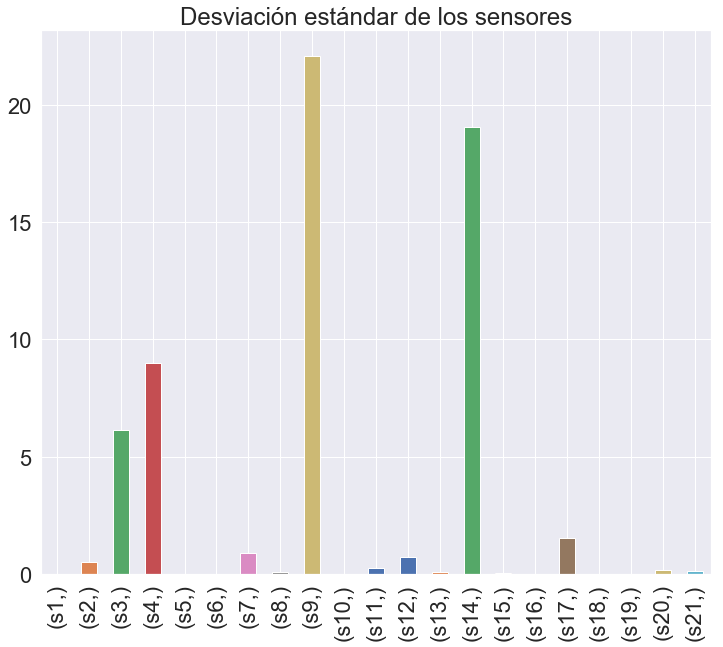

In [5]:
data2.std().plot(kind='bar', figsize=(12, 10), title = 'Desviación estándar de los sensores')

C:\Users\Porti\Anaconda3\lib\site-packages\pandas\core\generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


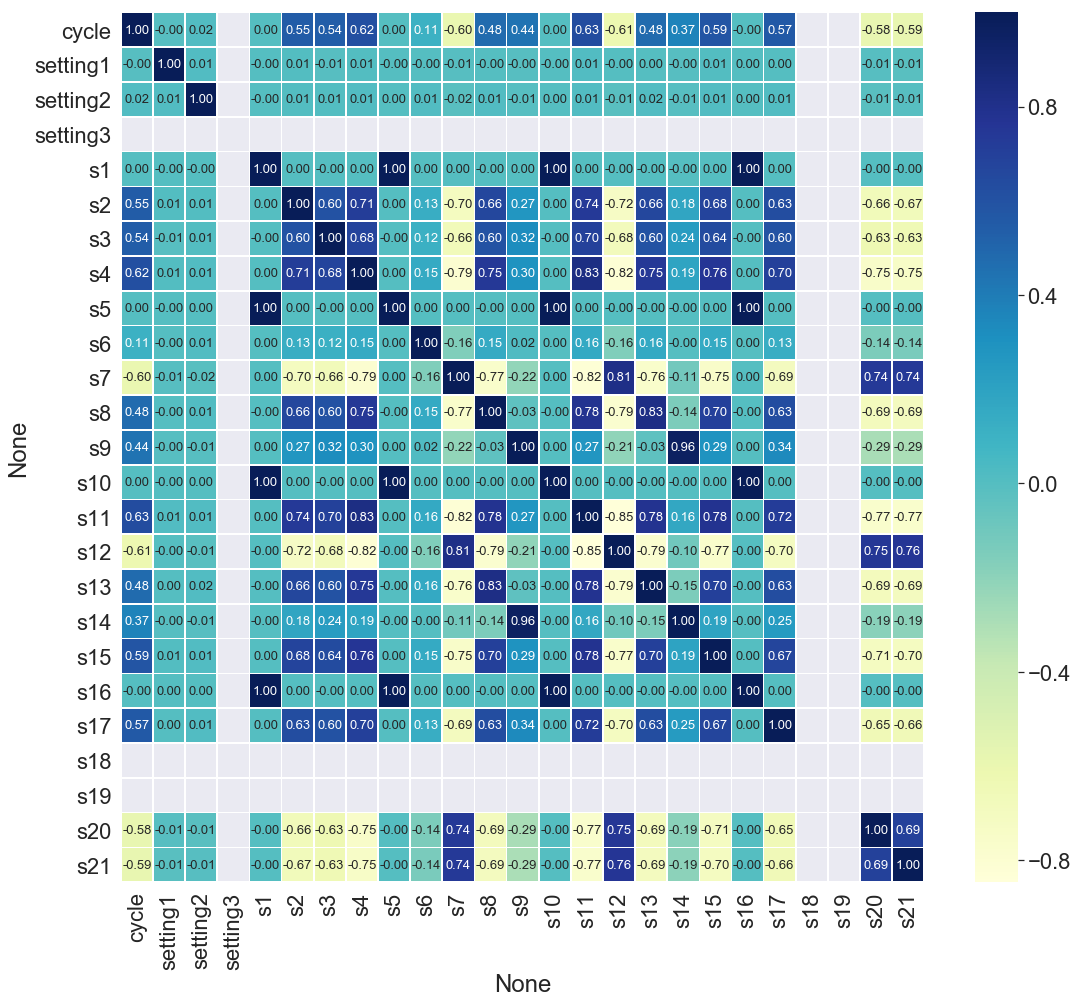

In [6]:
# Matriz de correlación

plt.figure(figsize = (18, 16))
sns.heatmap(data.drop(['id_unit'], axis = 1).corr(), annot= True, fmt='0.2f', annot_kws={'size': 13}, linewidths=.7, cmap="YlGnBu")
plt.show()

In [7]:
# Datos estadísticos de la data de entrenamiento.

data.describe(include='all')

,id_unit,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


Hay 100 simulaciones, cada simulación tiene entre 1 a 362 ciclos (con un promedio de 108 ciclos por simulación). Donde, el último ciclo para cada simulación representa el ciclo donde ocurrió la falla.

In [8]:
def outliers(columna):
    quantile_25 = data[columna].quantile(0.25)
    quantile_75 = data[columna].quantile(0.75)
    IQR = quantile_75 - quantile_25

    a = quantile_25-1.5*(IQR)
    b = quantile_75+1.5*(IQR)

    d = data[columna]
    d1 = d[(d[columna] >= a) & (d[columna] <= b)]
    d1 = d1.dropna(how='all', axis=0)

    fig = plt.figure(figsize = (14, 12))

    sub1 = fig.add_subplot(221) 
    sub1.set_title('Con outliers') 
    sub1.boxplot(data[columna].values)

    sub2 = fig.add_subplot(222)
    sub2.set_title('Sin outliers')
    sub2.boxplot(d1[columna].values)

    plt.show()

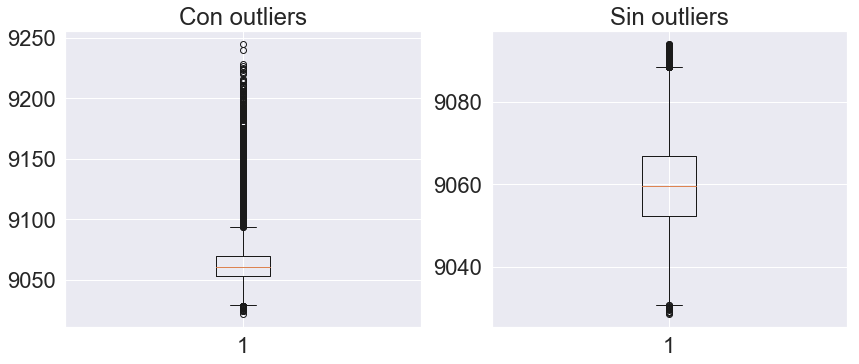

In [9]:
outliers('s9')

In [10]:
engine_1 = data[data.id_unit == 1]
print(engine_1.head())

  id_unit cycle setting1 setting2 setting3  s1  s2  s3  s4  s5 ... s12 s13  \
0     1.0   NaN      NaN      NaN      NaN NaN NaN NaN NaN NaN ... NaN NaN   
1     1.0   NaN      NaN      NaN      NaN NaN NaN NaN NaN NaN ... NaN NaN   
2     1.0   NaN      NaN      NaN      NaN NaN NaN NaN NaN NaN ... NaN NaN   
3     1.0   NaN      NaN      NaN      NaN NaN NaN NaN NaN NaN ... NaN NaN   
4     1.0   NaN      NaN      NaN      NaN NaN NaN NaN NaN NaN ... NaN NaN   

  s14 s15 s16 s17 s18 s19 s20 s21  
0 NaN NaN NaN NaN NaN NaN NaN NaN  
1 NaN NaN NaN NaN NaN NaN NaN NaN  
2 NaN NaN NaN NaN NaN NaN NaN NaN  
3 NaN NaN NaN NaN NaN NaN NaN NaN  
4 NaN NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 26 columns]
